In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from csgwsim.Noise import LISANoise, TianQinNoise
from csgwsim.Constants import MPC_SI

In [31]:
%run test_fastgb.py

TypeError: 'module' object is not callable

In [1]:
%run Generate_GW_Data.py

This is TD response generation code
Testing of gcb waveform
Time cost is 1.464769 s for 864000 points
Time cost for cal XYZ and AET with yslr is  0.018010854721069336


In [2]:
%run test_Noise.py

In [3]:
gcb_TX_td = np.load("TQgcb_X_td.npy")

In [4]:
emri_TX_td = np.load("TQemri_X_td.npy")

In [5]:
gcb_TX_td.shape, emri_TX_td.shape

((2, 864000), (2, 864000))

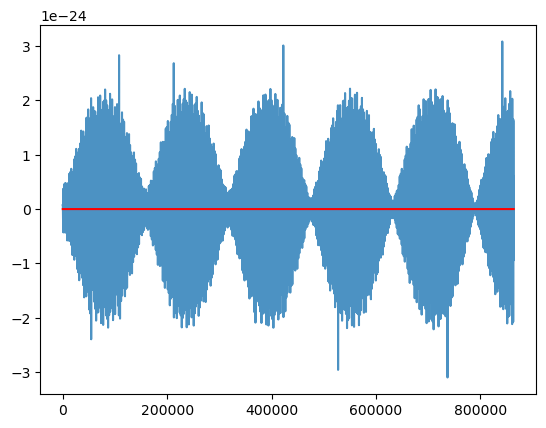

In [6]:
plt.plot(emri_TX_td[0], emri_TX_td[1], alpha=0.8)
plt.plot(gcb_TX_td[0], gcb_TX_td[1], "r")

In [7]:
noise_TX = np.load("noise_TX.npy")

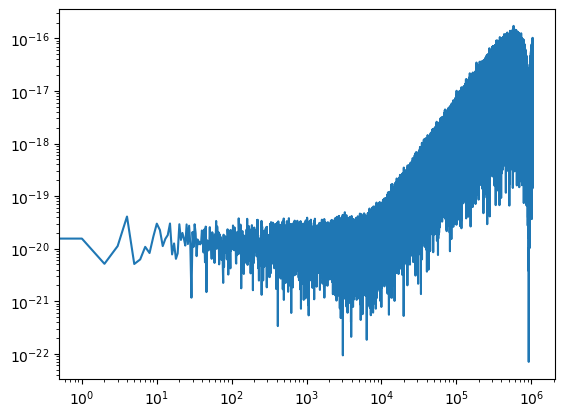

In [8]:
plt.plot(np.abs(noise_TX))
plt.xscale('log')
plt.yscale('log')

In [9]:
noise_TX_td = np.fft.irfft(noise_TX)

In [10]:
noise_TX_td.shape, gcb_TX_td.shape

((2097150,), (2, 864000))

Text(0.5, 1.0, 'GCB+EMRI with noise')

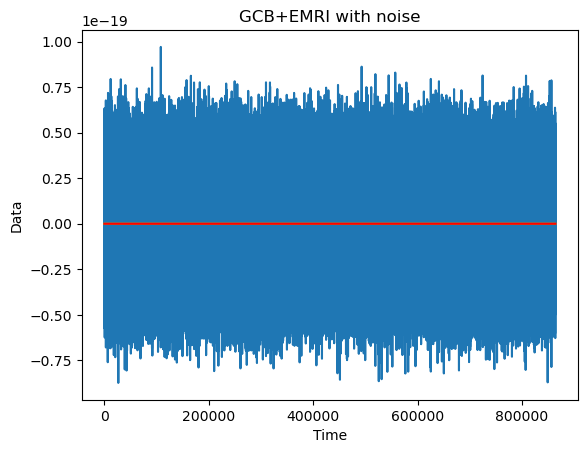

In [25]:
plt.plot(noise_TX_td[:864000])
plt.plot(emri_TX_td[1], 'y')
plt.plot(gcb_TX_td[1], 'r')

plt.xlabel("Time")
plt.ylabel("Data")
plt.title("GCB+EMRI with noise")

Text(0.5, 1.0, 'GCB + EMRI without noise')

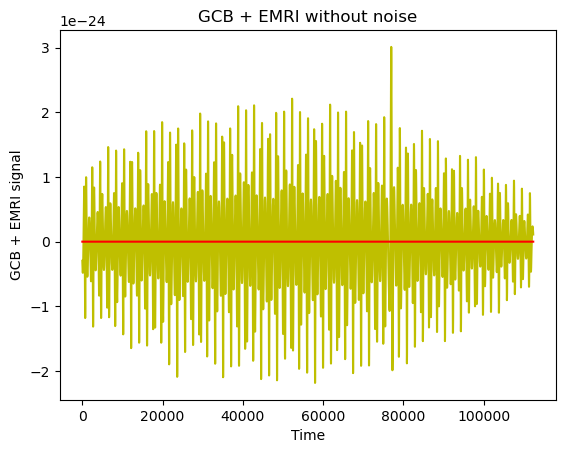

In [26]:
#plt.plot(noise_TX_fd[:864000])
#plt.plot(gcb_TX_td[0], gcb_TX_td[1], 'r')
#plt.plot(noise_TX_fd[1000:80000])
plt.plot(emri_TX_td[1][86400*4:int(86400*5.3)], 'y')
plt.plot(gcb_TX_td[1][86400*4:int(86400*5.3)], 'r')

plt.xlabel("Time")
plt.ylabel("GCB + EMRI signal")
plt.title("GCB + EMRI without noise")

Text(0.5, 1.0, 'GCB without noise')

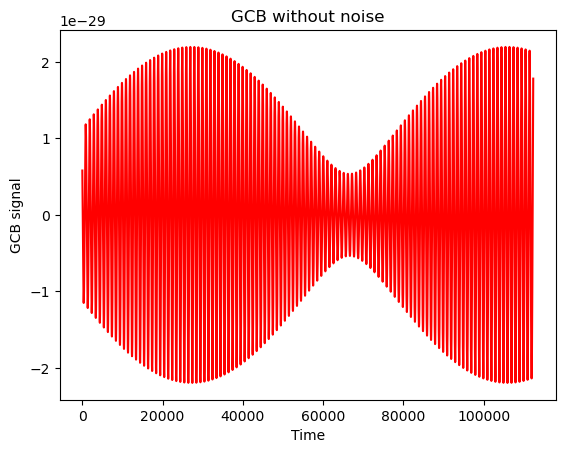

In [24]:
#plt.plot(emri_TX_td[1][86400*4:int(86400*5.3)], 'y')
plt.plot(gcb_TX_td[1][86400*4:int(86400*5.3)], 'r')

plt.xlabel("Time")
plt.ylabel("GCB signal")
plt.title("GCB without noise")

In [30]:
gcb_TX_td.shape[1]/3600/24

10.0

In [21]:
from csgwsim.FastEMRI import *

In [22]:
few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [23]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dt = 10.0

wave = few(M, mu, p0, e0, theta, phi, dt=dt, T=1.0)  #  assumes dt = 10.0 for max T = 1.0 year

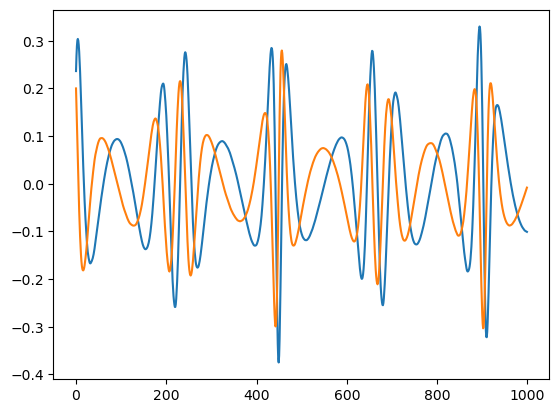

In [24]:
dt = 10.0
t = np.arange(len(wave)) * dt

plt.plot(wave.real[:1000])
plt.plot(wave.imag[:1000])

This is TD response generation code
Testing of emri waveform
Time cost is 30.024221 s for 864000 points
Time cost for cal XYZ and AET with yslr is  0.03822493553161621


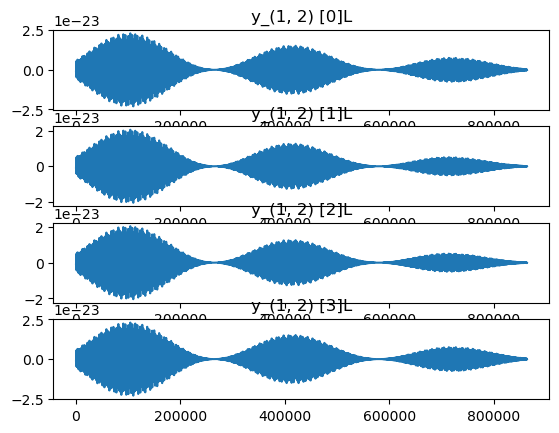

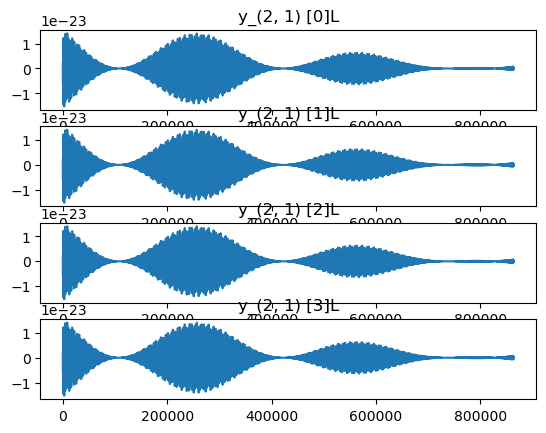

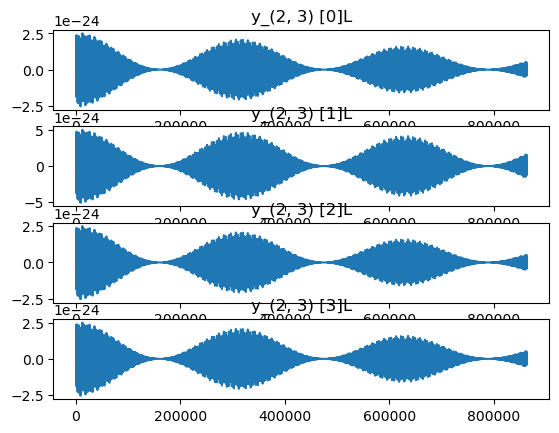

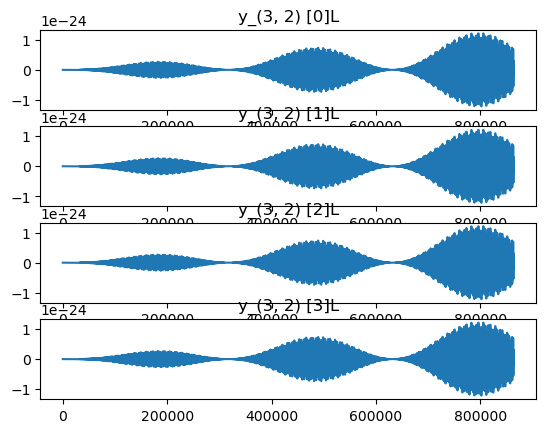

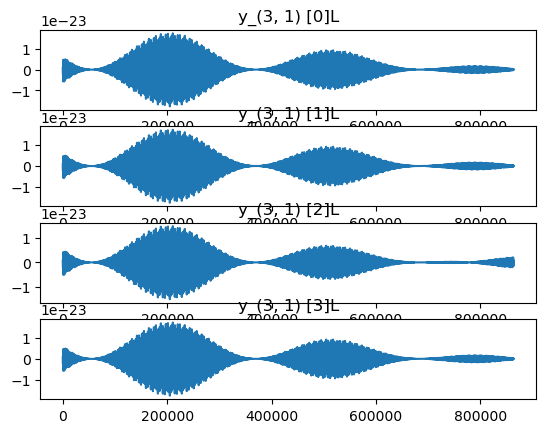

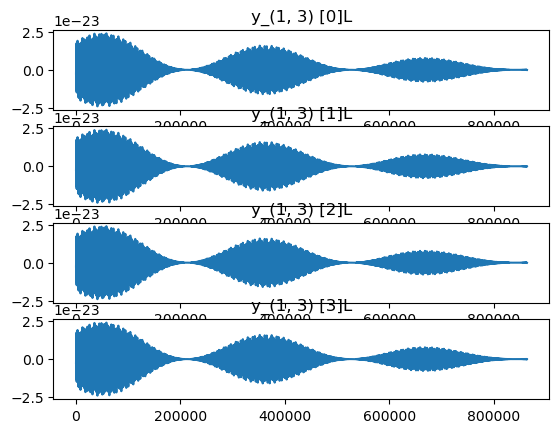

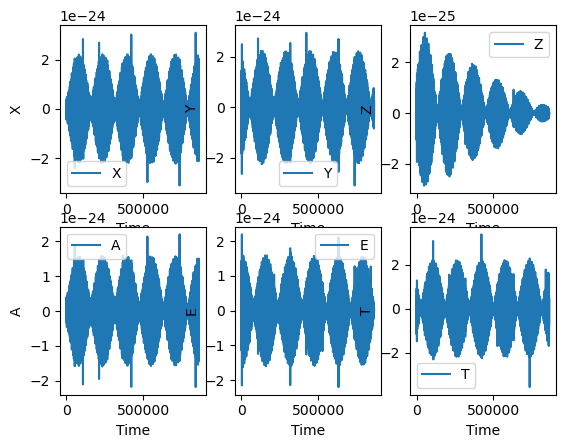

In [1]:
%run Generate_GW_Data.py

In [6]:
import csgwsim.Waveform as WF
from csgwsim.Waveform import waveforms
from csgwsim.response import get_td_response
from csgwsim.Orbit import TianQinOrbit, detectors
from csgwsim.Constants import DAY, YRSID_SI
from csgwsim.TDI import XYZ_TD

In [7]:
Tobs = 4* DAY
T = Tobs/YRSID_SI
dt = 1
tf = np.arange(0,Tobs,dt)

tf.shape

(345600,)

In [8]:
GCBpars = {"type": "GCB",
               "Mc": 0.5,
               "DL": 0.3,
               "phi0": 0.0,
               "f0": 0.001,
               "psi": 0.2,
               "iota": 0.3,
               "Lambda": 0.4,
               "Beta": 1.2,
               "T_obs": YRSID_SI,
               }

EMRIpars = {"type": "emri",
                'M': 1e6,
                'a': 0.1,
                'mu': 1e1,
                'p0': 12.0,
                'e0': 0.2,
                'x0': 1.0,
                'qK': 0.2,
                'phiK': 0.2,
                'qS': 0.3,
                'phiS': 0.3,
                'dist': 1.0,
                'Phi_phi0': 1.0,
                'Phi_theta0': 2.0,
                'Phi_r0': 3.0,
                'psi': 0.4,
                'iota': 0.2,
                }

#help(WF.GCBWaveform)
GB = WF.GCBWaveform(**GCBpars)

In [9]:
emriwf = waveforms[EMRIpars['type']]

wf_emri = emriwf(**EMRIpars)

In [13]:
help(wf_emri.get_hphc)

Help on method get_hphc in module csgwsim.Waveform:

get_hphc(Tobs, dt, eps=1e-05, modes=None) method of csgwsim.Waveform.EMRIWaveform instance
    Calculate the time domain waveforms
    -----------------------------------
    Return:
    - hp, hc
    
    Parameters:
    - Tobs: the observation time in [year]
    - dt: sampling time in [s]
    - modes: (str or list or None)
        - If None, perform our base mode filtering with eps as the fractional accuracy on the total power.
        - If ‘all’, it will run all modes without filtering.
        - If a list of tuples (or lists) of mode indices (e.g. [(l1,m1,n1), (l2,m2,n2)]) is provided,
            it will return those modes combined into a single waveform.
    - eps: Controls the fractional accuracy during mode filtering.
        Raising this parameter will remove modes.
        Lowering this parameter will add modes.
        Default that gives a good overlap is 1e-5.



In [20]:
wf_emri.mass1

AttributeError: mass1

In [18]:

hp, hc = GB.get_hphc(tf)

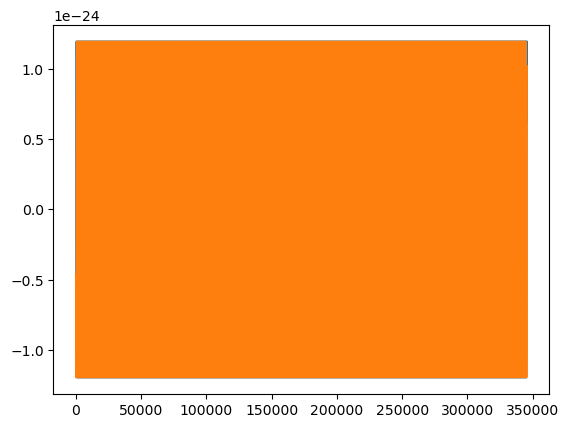

In [19]:
plt.plot(tf, hp)
plt.plot(tf, hc)

In [20]:
tq = detectors['TQ']

In [21]:
TQ = tq(tf)

In [22]:
yslr = get_td_response(GB, TQ, tf)

In [23]:
yslr

{(1,
  2): {'0L': array([ 1.85953766e-28,  1.91285216e-28,  1.96609652e-28, ...,
         -1.21921319e-27, -1.22917072e-27, -1.23908002e-27]), '1L': array([ 1.82869484e-28,  1.88205046e-28,  1.93533715e-28, ...,
         -1.21344159e-27, -1.22342689e-27, -1.23336418e-27]), '2L': array([ 1.79782793e-28,  1.85122396e-28,  1.90455228e-28, ...,
         -1.20765400e-27, -1.21766693e-27, -1.22763209e-27]), '3L': array([ 1.76693733e-28,  1.82037306e-28,  1.87374231e-28, ...,
         -1.20185050e-27, -1.21189093e-27, -1.22188383e-27])},
 (2,
  1): {'0L': array([ 1.85953450e-28,  1.91284891e-28,  1.96609318e-28, ...,
         -1.21921246e-27, -1.22916998e-27, -1.23907927e-27]), '1L': array([ 1.82869174e-28,  1.88204726e-28,  1.93533386e-28, ...,
         -1.21344086e-27, -1.22342615e-27, -1.23336344e-27]), '2L': array([ 1.79782488e-28,  1.85122081e-28,  1.90454904e-28, ...,
         -1.20765327e-27, -1.21766620e-27, -1.22763135e-27]), '3L': array([ 1.76693433e-28,  1.82036997e-28,  1.87373912

In [25]:
X,Y,Z = XYZ_TD(yslr=yslr)

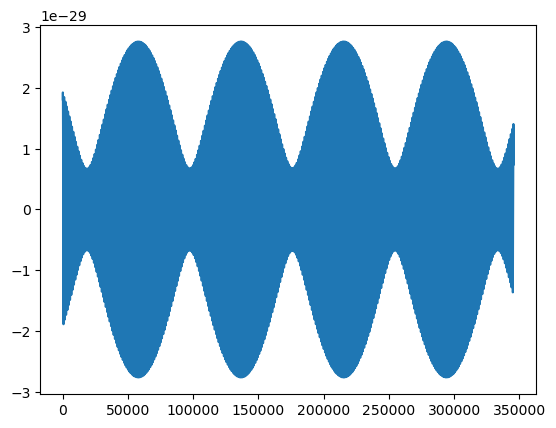

In [27]:
plt.plot(tf, X)

In [2]:
def powerlaw_psd_gaussian(exponent, size, fmin=0, random_state=None):
    """Gaussian (1/f)**beta noise.

    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)

    Normalised to unit variance

    Parameters:
    -----------

    exponent : float
        The power-spectrum of the generated noise is proportional to

        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2

        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.

    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.

    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. 
        
        The power-spectrum below fmin is flat. fmin is defined relative
        to a unit sampling rate (see numpy's rfftfreq). For convenience,
        the passed value is mapped to max(fmin, 1/samples) internally
        since 1/samples is the lowest possible finite frequency in the
        sample. The largest possible value is fmin = 0.5, the Nyquist
        frequency. The output for this value is white noise.

    random_state :  int, numpy.integer, numpy.random.Generator, numpy.random.RandomState, 
                    optional
        Optionally sets the state of NumPy's underlying random number generator.
        Integer-compatible values or None are passed to np.random.default_rng.
        np.random.RandomState or np.random.Generator are used directly.
        Default: None.

    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    try:
        size = list(size)
    except TypeError:
        size = [size]
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples)
    
    # Validate / normalise fmin
    if 0 <= fmin <= 0.5:
        fmin = max(fmin, 1./samples) # Low frequency cutoff
    else:
        raise ValueError("fmin must be chosen between 0 and 0.5.")
    
    # Build scaling factors for all frequencies
    s_scale = f    
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # prepare random number generator
    normal_dist = _get_normal_distribution(random_state)

    # Generate scaled random power + phase
    sr = normal_dist(scale=s_scale, size=size)
    si = normal_dist(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2):
        si[..., -1] = 0
        sr[..., -1] *= sqrt(2)    # Fix magnitude
    
    # Regardless of signal length, the DC component must be real
    si[..., 0] = 0
    sr[..., 0] *= sqrt(2)    # Fix magnitude
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y


def _get_normal_distribution(random_state):
    normal_dist = None
    if isinstance(random_state, (integer, int)) or random_state is None:
        random_state = default_rng(random_state)
        normal_dist = random_state.normal
    elif isinstance(random_state, (Generator, RandomState)):
        normal_dist = random_state.normal
    else:
        raise ValueError(
            "random_state must be one of integer, numpy.random.Generator, "
            "numpy.random.Randomstate"
        )
    return normal_dist

In [7]:
from csgwsim.Noise import TianQinNoise, LISANoise, noise_XYZ, noise_AET
from csgwsim.Constants import PI, C_SI

freq = np.linspace(1e-4, 1, 1001)

tq = TianQinNoise()
tq_sa, tq_sp = tq.noises(freq)
TX, TXY = noise_XYZ(freq, tq_sa, tq_sp, tq.armL)

noise_TX = powerlaw_psd_gaussian(TX, 2**20, fmin=freq[0])

NameError: name 'rfftfreq' is not defined

In [4]:
2**20

1048576